In [1]:
## imports

import numpy as np
import matplotlib.pyplot as plt

In [2]:
## constants

HZ = 30 #ticks per second
MAX_SPEED = 10 # cm/s
MAX_OFFSET = 20 # cm
POS_INCREMENTS = 0.01 # cm
RFID_RANGE = 5 # cm
WALL_OFFSET = 25 # cm
STOPPING_DIST = -30 # cm
HANDSHAKE_TIME = 1 # sec
TIMEOUT = 1000 # ticks

In [3]:
## derived constants

n_pts = int(MAX_OFFSET * 2 / POS_INCREMENTS) + 1
waypoint_positions = np.linspace(-MAX_OFFSET, MAX_OFFSET, n_pts)
handshake_ticks = HANDSHAKE_TIME * HZ
time = np.linspace(0, TIMEOUT / HZ, TIMEOUT)

In [4]:
class approach_strategy(object):
    def __init__(self):
        self.stopping_point = 0
        self.starting_velocity = 0
        self.velocities = self.starting_velocity * np.ones(TIMEOUT)
        self.pos = self.stopping_point
        
    def step(self, i):
        self.pos += self.velocities[i] / HZ
        return self.pos

In [5]:
current_strategy = approach_strategy()

In [6]:
creep_forward = approach_strategy()
creep_forward.velocities = np.linspace(creep_forward.starting_velocity, MAX_SPEED / 2, TIMEOUT)
creep_forward.pos = creep_forward.stopping_point + STOPPING_DIST

In [7]:
creep_back = approach_strategy()
creep_back.velocities = np.linspace(0, -MAX_SPEED, TIMEOUT)
creep_back.pos = creep_back.stopping_point + WALL_OFFSET

In [8]:
wiggle = approach_strategy()
wiggle.velocities = MAX_SPEED * np.sin((np.pi / 2) * time)

In [9]:
def check_rfid(bot_pos, rfid_pos):
    return abs(bot_pos - rfid_pos) <= RFID_RANGE

def run_approach_sim(strategy):
    times = []
    for i in range(len(waypoint_positions)):
        rfid_pos = waypoint_positions[i]
        rfid_timeout = 0
        handshake = 0
        for j in range(len(time)):
            if check_rfid(strategy.pos, rfid_pos) and rfid_timeout <= 0:
                if handshake == 0:
                    handshake = 1
                    rfid_timeout = handshake_ticks
                elif handshake == 1:
                    handshake = 2
                    times.append(time[j])
            if handshake < 2:
                strategy.step(j)
                rfid_timeout -= 1
            #print(time[j], strategy.pos, rfid_pos, handshake, rfid_timeout)
        if handshake < 2:
            times.append(time[j])
            
    return times

In [10]:
def plot_run(approach_time, strat_name = ""):
    plt.figure()
    plt.title("strat_name")
    plt.xlabel("location offset (cm)")
    plt.ylabel("time to handshake (s)")
    plt.plot(waypoint_positions, approach_time, 'k*')
    plt.plot([-MAX_OFFSET, MAX_OFFSET], [np.mean(approach_time)] * 2, 'r')
    plt.plot([-MAX_OFFSET, MAX_OFFSET], [np.median(approach_time)] * 2, 'g')
    plt.show()

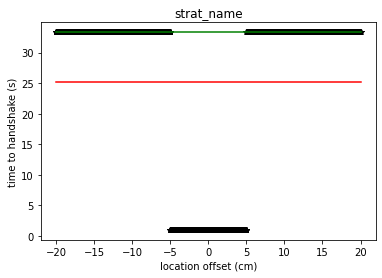

In [11]:
cur_approach_time = run_approach_sim(current_strategy)
plot_run(cur_approach_time, strat_name = "current")

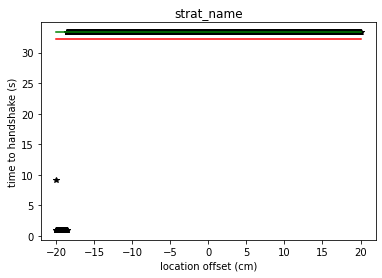

In [12]:
fwd_approach_time = run_approach_sim(creep_forward)
plot_run(fwd_approach_time, strat_name = "forward")

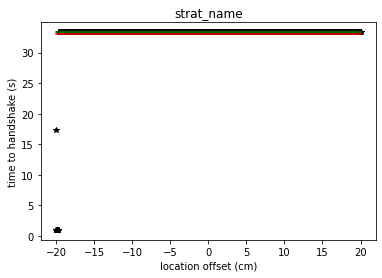

In [13]:
back_approach_time = run_approach_sim(creep_back)
plot_run(back_approach_time, strat_name = "backward")

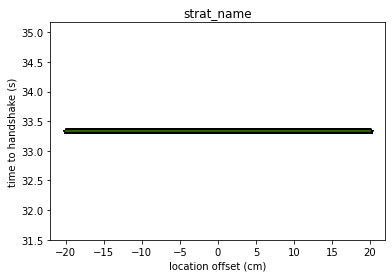

In [14]:
wiggle_approach_time = run_approach_sim(wiggle)
plot_run(wiggle_approach_time, strat_name = "wiggle")